In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.algorithms import VQR
from qiskit.algorithms.optimizers import L_BFGS_B
import time
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_790/3331218195.py:10: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import L_BFGS_B


In [2]:
df = pd.read_csv(".././data/cleanDataset.csv")
df.head()

,Molecular Weight (g/mol),pKa,Log P,Log S,Polar Surface Area (Å2),Polarizability (Å3),HOMO (eV),LUMO (eV),Ionization Energy (eV),Electron Affinity (eV),Electronegativity (eV),Hardness (eV),Electrophilicity (eV),ΔN_Fe,IE (%)
0,194.19,14.00,-0.07,-0.97,58.44,18.96,-5.769,-1.977,5.769,1.977,3.873,1.896,0.96825,0.824631,92.0
1,151.16,9.90,0.91,-1.60,49.33,15.52,-5.494,-1.646,5.494,1.646,3.570,1.924,0.89250,0.891372,85.8
2,222.30,8.80,-0.26,-2.36,115.04,19.16,-7.010,-3.358,7.010,3.358,5.184,1.826,1.29600,0.497262,93.0
3,60.05,4.80,-0.17,1.22,37.30,5.34,-6.816,-1.070,6.816,1.070,3.943,2.873,0.98575,0.532022,92.0
4,137.14,3.38,0.83,-0.40,63.32,13.44,-5.922,-2.122,5.922,2.122,4.022,1.900,1.00550,0.783684,80.0


In [3]:
X = df.drop("IE (%)", axis=1)
y = df["IE (%)"]

In [4]:
minMaxScaler = MinMaxScaler()
X_scaled = minMaxScaler.fit_transform(X)

In [5]:
# Apply PCA
num_components = 0.95  # Choose the number of components you want to keep
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape[1]

5

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

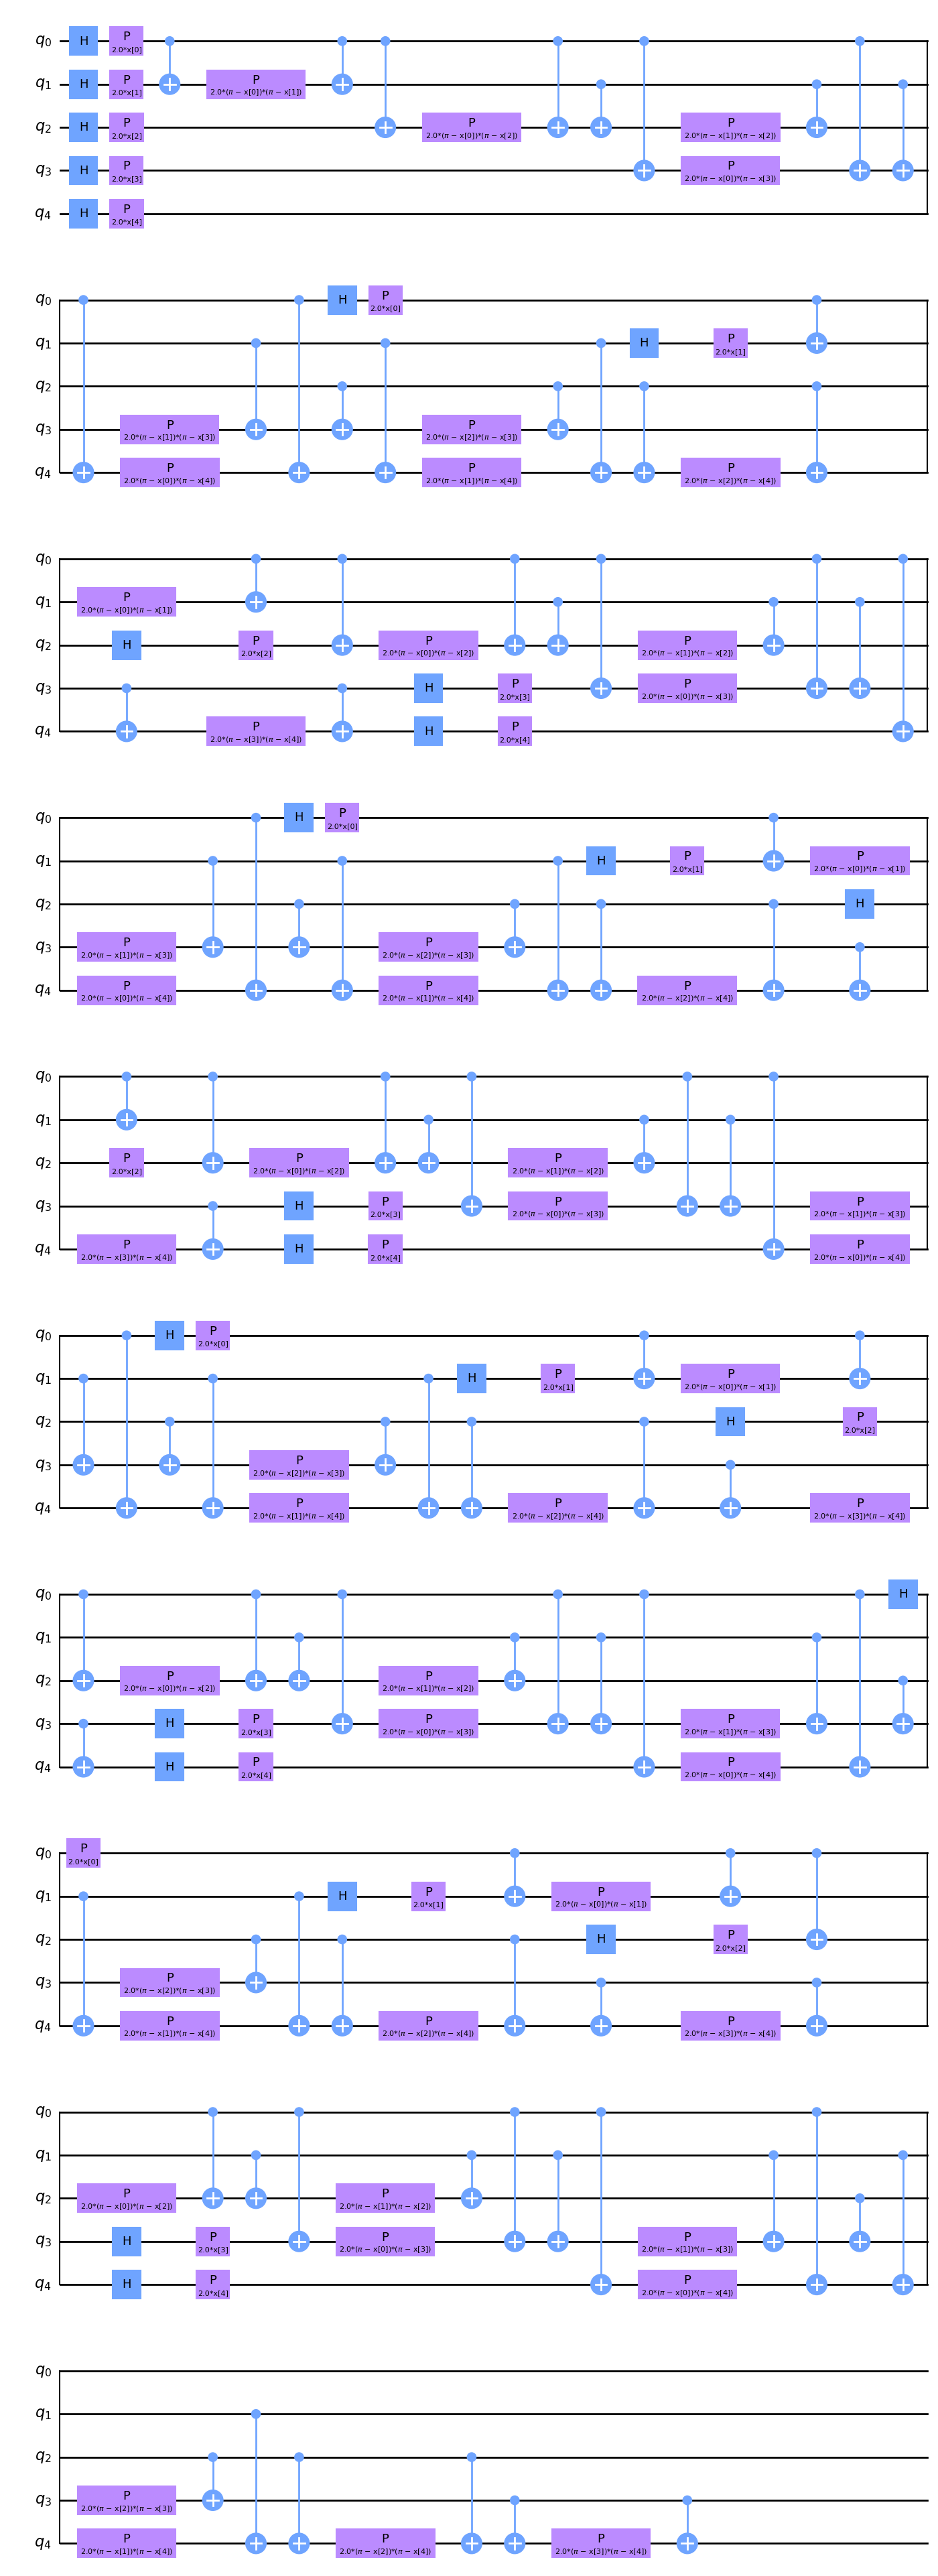

In [7]:
num_featrue = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_featrue, reps=5)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

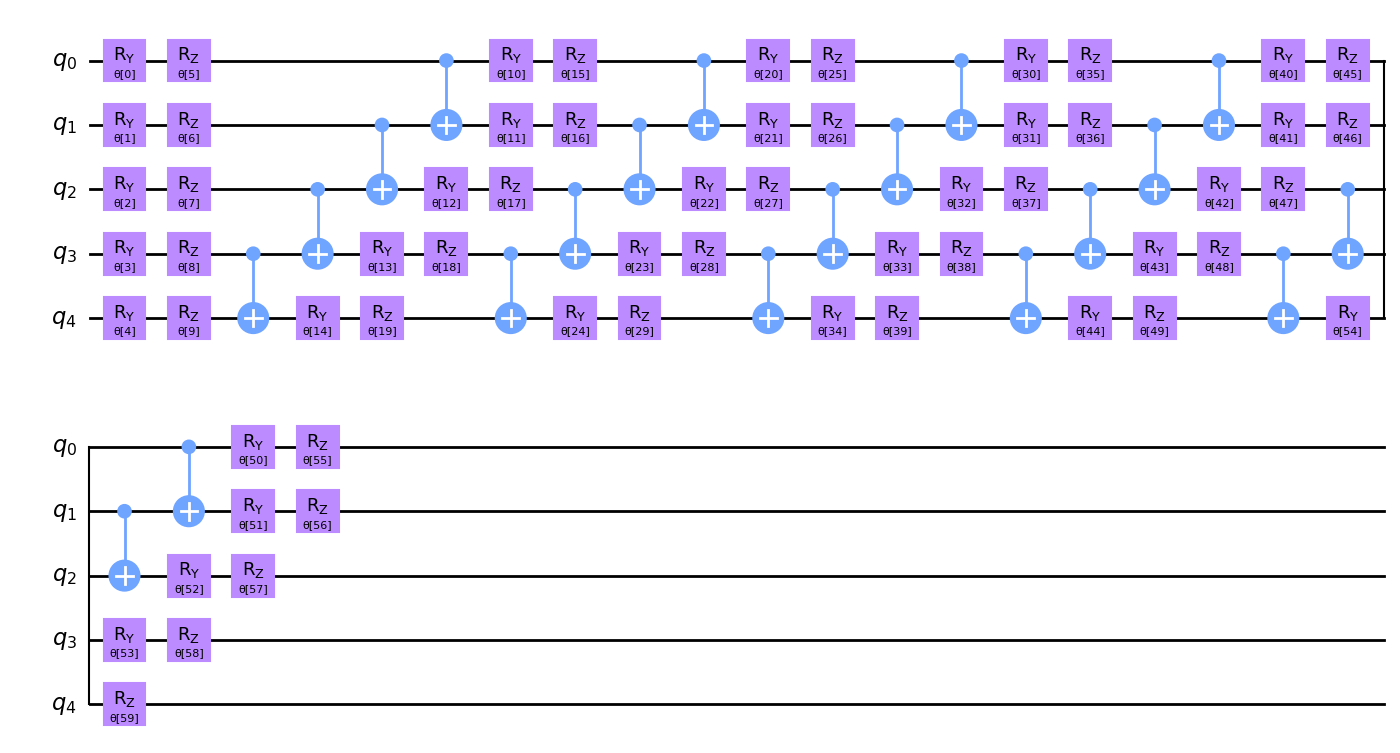

In [8]:
ansatz = EfficientSU2(num_qubits=num_featrue, reps=5)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [9]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

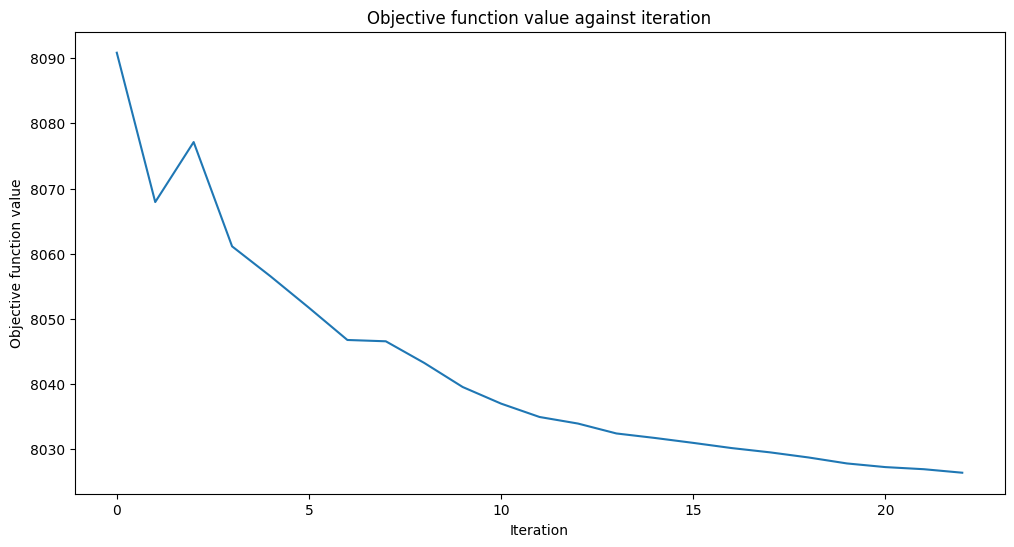

Training time: 1253 seconds


In [10]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=20),
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqr.fit(X_train, y_train.ravel())
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [11]:
y_pred = vqr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)

print(f"Training time: {round(elapsed)} seconds")
print(f'MSE: {mse}')
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {rsquare}")

Training time: 1253 seconds
MSE: 7955.426416772047
RMSE: 89.19319714402016
MAPE: 0.9978190628560651
R2: -239.88073480176158
